In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import random
import math

**Data**

In [2]:
words = open('../makemore_data/names.txt').read().splitlines()

# Vocab
chars = sorted(list(set(''.join(words)))) ##unique characters ordered
stoi = {s:i+1 for i, s in enumerate(chars)} ##create dictionary mapping from char to int
stoi['.'] = 0 ##just one special character for start and end of word
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [3]:
def make_data(words, block_size=3):
    chars = sorted(list(set(''.join(words)))) ##unique characters ordered
    stoi = {s:i+1 for i, s in enumerate(chars)} ##create dictionary mapping from char to int
    stoi['.'] = 0 ##just one special character for start and end of word
    itos = {i:s for s, i in stoi.items()}

    # Data
    ## block_size = context length: how many chars do we use to predict the next?

    X, Y = [], []
    for w in words[:]:
        # print(f"{w}:")

        context = [0] * block_size #start with padded context of just 0 tokes ('.')
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), "-->", itos[ix])
            context = context[1:] + [ix] #crop the context vector and append the new index


    X = torch.tensor(X)
    Y = torch.tensor(Y)

    n_samples = X.shape[0]
    print(f"{ n_samples = }")

    return X, Y


def split_samples(inputs, labels, frac=0.8, seed=123):
    "Split xs and ys (inputs and labels) into train and test sets"
    
    assert len(inputs)==len(labels), f"{len(inputs) = } which does not match {len(labels) = }"
    # generate a list of indices to exclude. Turn in into a set for O(1) lookup time
    random.seed(seed)
    indx = list(set(random.sample(list(range(len(inputs))), int(frac*len(inputs)))))

    x_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    x_mask[indx] = True

    y_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    y_mask[indx] = True

    train_x = inputs[x_mask]
    train_y = labels[y_mask]

    test_x = inputs[~x_mask]
    test_y = labels[~y_mask]

    return train_x, train_y, test_x, test_y

## PyTorch Implementation

In [7]:
# MAKING DATA & SPLITTING
block_size = 3
X, Y = make_data(words[:30], block_size)

Xtr, Ytr, Xte, Yte = split_samples(X, Y, 0.8)
Xdev, Ydev, Xte, Yte = split_samples(Xte, Yte, 0.5)

print("Train %:", Xtr.shape[0]/X.shape[0], 
      "\nDev %:", Xdev.shape[0]/X.shape[0],
      "\nTest %:", Xte.shape[0]/X.shape[0])

 n_samples = 199
Train %: 0.7989949748743719 
Dev %: 0.10050251256281408 
Test %: 0.10050251256281408


In [8]:
device = torch.device(device="cpu")

In [199]:
n_chars = len(stoi)
class MLP(torch.nn.Module):
    def __init__(self, emb_dim, hidden_neurons) -> None:
        super().__init__()

        self.C = torch.nn.Embedding(num_embeddings=n_chars, embedding_dim=emb_dim) #device=device...whatever we're on cpu
        self.linear = torch.nn.Linear(in_features=emb_dim*block_size, out_features=hidden_neurons, bias=False)
        self.bn = torch.nn.BatchNorm1d(num_features=hidden_neurons, momentum=0.01, track_running_stats=True)
        self.head = torch.nn.Linear(in_features=hidden_neurons, out_features=n_chars, bias=True)

    def forward(self, x):
        """x, y=None"""
        emb = self.C(x)
        embcat = emb.view(emb.shape[0], -1) ##preserve first dim and concat last 2
        lin = self.linear(embcat)
        bn = self.bn(lin)
        relu = torch.relu(bn)
        logits = self.head(relu)
        
        return logits

In [243]:
model = MLP(10, 100)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

In [255]:
batch_size = 64
epochs = 1

for ep in range(epochs):
    batch_permutation = torch.randperm(Xtr.shape[0])
    for step in range(0, Xtr.shape[0], batch_size):
        ix = batch_permutation[step:step+batch_size]
        batch_x, batch_y = Xtr[ix], Ytr[ix]

        model.zero_grad(set_to_none=True)
        # forward
        logits = model(batch_x)
        loss = loss_fn(logits, batch_y)
        # backward
        loss.backward()
        optimizer.step() 

print(loss.item())

1.0069853067398071


In [256]:
@torch.no_grad()
def split_loss(split):
    """Evalute model on desired split: train, val, or test"""
    model.eval()
    x,y = {"train":(Xtr,Ytr),"val":(Xdev,Ydev),"test":(Xte, Yte)}[split]
    # Forward pass
    logits = model(x)
    loss = loss_fn(logits, y)
    print(split, loss.item())
    # return loss
split_loss("train")
split_loss("test")
split_loss("val")

train 1.0180927515029907
test 2.866434335708618
val 3.000662088394165


In [272]:
# Sample from the model
seed = random.randint(100, 1000)
g = torch.Generator().manual_seed(seed)

@torch.no_grad()
def sample(n_names):
    model.eval()
    for _ in range(n_names):
        out_word = "."
        context = [0] * block_size ##initialize with all ...
        while True:
            logits = model(torch.tensor(context).unsqueeze(0))
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix] ##shift and append
            out_word += itos[ix]
            if ix == 0:
                break
        print("".join([c for c in out_word if c not in '.']))


sample(10)

jkka
asia
ora
paojeqh
eseijatiit
pmfibiia
chjme
heojc
kij
ekkj


# Diving Deeper
## Implement Torch Layers From Scratch

In [277]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility


## Train & 'Debug' a NN

In [447]:
vocab_size = len(stoi)
use_batch_norm = True ##set to False to see what happens to the results
gain = 5/3 ##for weight init


C = torch.randn((vocab_size, n_embd),            generator=g)
if use_batch_norm:
  layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size), #<- totally okay to include before loss fn
  ]
else:
  layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
  ]

with torch.no_grad():
  # last layer: make less confident
  if use_batch_norm:
    layers[-1].gamma *= 0.1
  else:
    layers[-1].weight *= 0.1

  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= gain


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


      0/ 200000: 0.6744


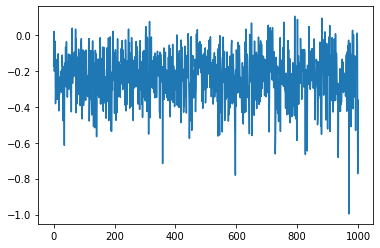

In [449]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.05 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

plt.plot(lossi);

### Visualize activation hists
We don't want to see big spikes at the tails - that indicates saturated neurons - would rather see a relatively flat distribution.  
At the least, if early layers are saturated we should hope for later layers to be less saturated.  

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 3.34%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 3.09%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.62%
layer 11 (      Tanh): mean +0.01, std 0.65, saturated: 2.66%
layer 14 (      Tanh): mean +0.01, std 0.65, saturated: 2.56%


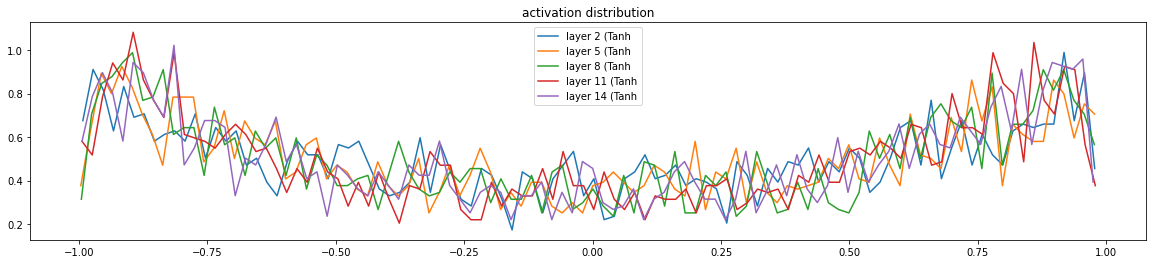

In [450]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution');

## Visualize gradient hists
We want the gradient dist to look roughly identical throughout the network - no vanishing or exploding.  

layer 2 (      Tanh): mean +0.000000, std 3.983987e-03
layer 5 (      Tanh): mean -0.000000, std 3.398315e-03
layer 8 (      Tanh): mean +0.000000, std 3.280798e-03
layer 11 (      Tanh): mean +0.000000, std 3.287209e-03
layer 14 (      Tanh): mean +0.000000, std 3.761780e-03


Text(0.5, 1.0, 'gradient distribution')

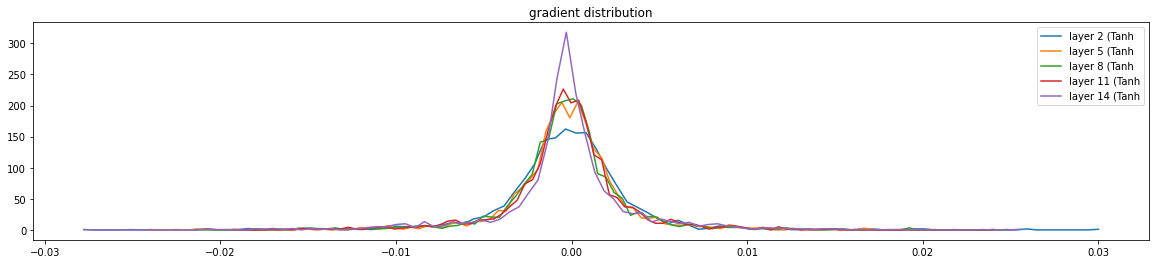

In [451]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')


### Visualize weight hists 
Visualize the weights to see how they evolve through the network - look for exploding weights or bad distribution.  
grad:data ratio - we want the gradient to weight ratio to be relatively small (see below for more)

weight   (27, 10) | mean +0.000000 | std 1.415999e-02 | grad:data ratio 1.427530e-02
weight  (30, 100) | mean +0.000304 | std 1.180253e-02 | grad:data ratio 3.859183e-02
weight (100, 100) | mean -0.000186 | std 9.754573e-03 | grad:data ratio 5.767794e-02
weight (100, 100) | mean +0.000074 | std 9.186066e-03 | grad:data ratio 5.471886e-02
weight (100, 100) | mean +0.000058 | std 8.416281e-03 | grad:data ratio 4.991711e-02
weight (100, 100) | mean -0.000005 | std 8.772671e-03 | grad:data ratio 5.217213e-02
weight  (100, 27) | mean -0.000270 | std 1.918603e-02 | grad:data ratio 1.105636e-01


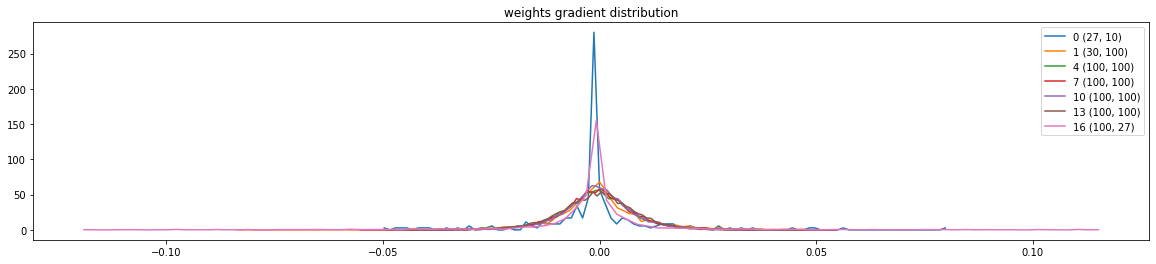

In [452]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

# Plot update to weight ratio
log(lr*weight.grad std. dev. / weight.data std. dev.)  

We want our updates to weights to be large enough that the network learns, but to be relatively small relative to the weights themself. By visualizing the update:weight ratio, we can see how the params are learning.  
If the updates are too big (for ex, due to too big of a LR or improper weight init), we may see a large ratio which indicates the neuron's weights are moving around a bit too much.  
Too low, and we may see a low ratio which indicates the network is training too slowly.  

~1e-3 is an ideal ratio (the black line), so if our update:weight ratio is close to this line (ideally close or below it) that's good (too much below it is bad - likely to low of a lr) 

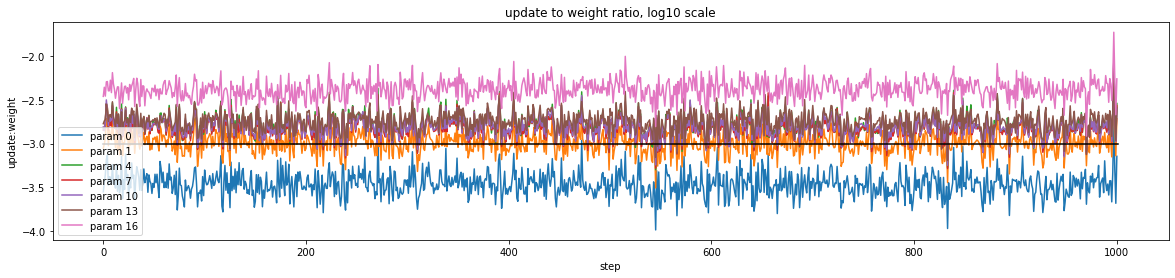

In [453]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.title("update to weight ratio, log10 scale")
plt.ylabel("update:weight")
plt.xlabel("step")
plt.legend(legends);